### 机器学习部分

1.针对相同的训练集，进行不同的机器学习模型测试并调整超参

2.挑选较强或者是学习能力较好的学习器进行集成学习

### 常用来测试的模型

1.线性回归类模型

    1.1 朴素线性模型
    
    1.2 基于L1的线性回归
    
    1.3 基于L2的线性回归
    
    1.4 ElasticNet
    
2.树回归-CART

    2.1 CART
    
    2.2 RF
    
    2.3 AdaBoost
    
    2.4 GBDT/XGBoost
    
3.SVM类型-SVR

4.神经网络类型-FC神经网络

5.集成学习



### 数据集的准备

In [1]:
import pandas as pd 

import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
train=pd.read_csv('./data/train_1.csv')
y=train['SalePrice']
train1=train.drop(['Id','SalePrice','Unnamed: 0'],axis=1)

### 对于离散数据记性Label Encode---OneHot的Encode

In [3]:
X=pd.get_dummies(train1).reset_index(drop=True)

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)

### 基础线性回归

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lm=LinearRegression()
lm.fit(X_train,y_train)
pred=lm.predict(X_test)
np.sqrt(mean_squared_error(y_test,pred))
np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))

0.1262780962215695

### 预处理 Preprocessing

In [6]:
from sklearn.pipeline import make_pipeline

In [7]:
from sklearn.preprocessing import RobustScaler

In [8]:
lm_model=make_pipeline(RobustScaler(),LinearRegression())

In [9]:
lm_model.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [10]:
#y_test

In [11]:
def benchmark(model):
    pred=model.predict(X_test)
    logrmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
    return logrmse

In [12]:
#benchmark(lm_model)

### RidgeRegression

In [13]:
from sklearn.linear_model import Ridge

In [14]:
ridge_model=Ridge(alpha=0.1)

In [15]:
ridge_model.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
benchmark(ridge_model)

0.12658320875065002

### 带有RobustScaler的回归

In [17]:
ridge_model_pipe=make_pipeline(RobustScaler(),Ridge(alpha=0.001))

In [18]:
ridge_model_pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [19]:
benchmark(ridge_model_pipe)

0.12628716775371895

### 带有CV的回归

解决一个冲突：训练集和评测集

k-fold交叉验证

In [20]:
from sklearn.model_selection import KFold

In [21]:
kfolds=KFold(n_splits=10,shuffle=True,random_state=123)

In [22]:
from sklearn.linear_model import RidgeCV

In [23]:
r_alphas=[0.01,0.1,1,3,5,7,10,100]

In [24]:
ridge_model_cv=make_pipeline(RobustScaler(),RidgeCV(alphas=r_alphas,cv=kfolds))

In [25]:
ridge_model_cv.fit(X_train,y_train)

/Users/deepglint/miniconda2/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridgecv', RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 3.e+00, 5.e+00, 7.e+00, 1.e+01, 1.e+02]),
    cv=KFold(n_splits=10, random_state=123, shuffle=True),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

In [26]:
benchmark(ridge_model_cv)

0.12385966794851823

In [27]:
def benchmark1(model,testset,label):
    pred=model.predict(testset)
    if pred[pred<0].shape[0]>0:
        print('Neg Value')
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(pred)))

    print('RMSE:',rmse)
    print('LRMSE:',lrmse)
    return lrmse

In [28]:
benchmark1(ridge_model_cv,X_test,y_test)

RMSE: 26907.89401651116
LRMSE: 0.12385966794851823


0.12385966794851823

In [29]:
r_alphas=[.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

In [30]:
def ridge_train_test(alpha):
    m=make_pipeline(RobustScaler(),RidgeCV(alphas=[alpha],cv=kfolds))
    m.fit(X_train,y_train)
    return benchmark1(m,X_test,y_test)

In [31]:
import warnings 
warnings.filterwarnings('ignore')

In [32]:
scores=[]
for k in r_alphas:
    scores.append(ridge_train_test(k))

RMSE: 24973.969248975565
LRMSE: 0.12627904574479823
RMSE: 24974.080818339156
LRMSE: 0.12628091580069659
RMSE: 24974.192243015987
LRMSE: 0.12628274791872882
RMSE: 24974.303534368606
LRMSE: 0.1262845429472097
RMSE: 24974.414703840674
LRMSE: 0.12628630171437566
RMSE: 24979.528134378193
LRMSE: 0.12633870541444303
RMSE: 25012.204406895555
LRMSE: 0.12641709913943716
RMSE: 25072.955925339633
LRMSE: 0.12658566764241627
RMSE: 25328.501950347658
LRMSE: 0.12762387547257203
RMSE: 25776.23152819279
LRMSE: 0.1299338626680368
RMSE: 26017.00830435279
LRMSE: 0.13133359554876897
RMSE: 26002.20207052294
LRMSE: 0.13104277583538676
RMSE: 25890.56856743901
LRMSE: 0.12971142906645244
RMSE: 25829.487235208784
LRMSE: 0.1286114851819151
RMSE: 25816.15857835699
LRMSE: 0.12775697253955298
RMSE: 25873.843585167833
LRMSE: 0.12652048146318876
RMSE: 26130.63901498296
LRMSE: 0.12506392340075095
RMSE: 26283.503890921835
LRMSE: 0.12462399114535531
RMSE: 26440.64590142592
LRMSE: 0.12430803900379388
RMSE: 26598.2928948717

In [33]:
import matplotlib.pyplot as plt

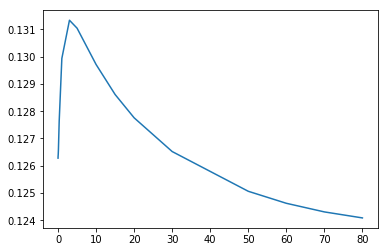

In [34]:
plt.plot(r_alphas,scores)

### RidgeCV自动筛选参数

In [35]:
r_alphas2=np.logspace(-10,2.8,150)

In [ ]:
scores=[]
for k in r_alphas2:
    scores.append(ridge_train_test(k))

RMSE: 24973.852287063975
LRMSE: 0.12627739055448864
RMSE: 24973.86484733172
LRMSE: 0.12627734970854296
RMSE: 24973.919457848533
LRMSE: 0.1262773089721718
RMSE: 24973.886860738843
LRMSE: 0.1262775162365863
RMSE: 24973.86548459176
LRMSE: 0.12627757563283298
RMSE: 24973.866965701694
LRMSE: 0.12627763993475374
RMSE: 24973.920255626148
LRMSE: 0.12627787333102453
RMSE: 24973.8822221939
LRMSE: 0.12627781619183312
RMSE: 24973.909196251152
LRMSE: 0.12627790939961944
RMSE: 24973.89435021205
LRMSE: 0.1262779096894281
RMSE: 24973.905324221552
LRMSE: 0.12627797232867416
RMSE: 24973.914245545366
LRMSE: 0.12627799837218343
RMSE: 24973.9067444382
LRMSE: 0.12627799837949163
RMSE: 24973.899924356465
LRMSE: 0.12627799450363278
RMSE: 24973.910867324626
LRMSE: 0.1262780316900959
RMSE: 24973.91517201013
LRMSE: 0.12627805796944286
RMSE: 24973.909602540374
LRMSE: 0.12627805182940302
RMSE: 24973.912145592974
LRMSE: 0.12627806144139872
RMSE: 24973.90821997247
LRMSE: 0.12627806242572887
RMSE: 24973.912723794543


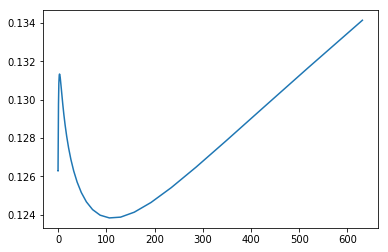

In [ ]:
plt.plot(r_alphas2,scores)

In [ ]:
ridge_model2=make_pipeline(RobustScaler(),RidgeCV(alphas=r_alphas2,cv=kfolds)).fit(X_train,y_train)

In [ ]:
benchmark1(ridge_model2,X_test,y_test)

RMSE: 25983.546991372652
LRMSE: 0.1257025386139876


0.1257025386139876

In [ ]:
ridge_model2.steps[1][1].alpha_

39.56538865832277

### Lasso Regression

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
l_alphas=np.logspace(-10,2.8,150)

In [ ]:
def lasso_train_test(alpha):
    lasso_model=make_pipeline(RobustScaler(),LassoCV(alphas=[alpha],cv=kfolds))
    lasso_model.fit(X_train,y_train)
    lrmse=benchmark1(lasso_model,X_test,y_test)
    return lrmse

In [ ]:
scores=[]
for k in l_alphas:
    print("Alpha:",k)
    scores.append(lasso_train_test(k))

Alpha: 1e-10
RMSE: 24910.98707880672
LRMSE: 0.12669462621586894
Alpha: 1.2187258987140784e-10
RMSE: 24910.987079200237
LRMSE: 0.12669462621633484
Alpha: 1.4852928161964384e-10
RMSE: 24910.987079679824
LRMSE: 0.1266946262169026
Alpha: 1.810164822272569e-10
RMSE: 24910.987080264214
LRMSE: 0.12669462621759428
Alpha: 2.206094749844747e-10
RMSE: 24910.98708097653
LRMSE: 0.1266946262184376
Alpha: 2.6886248066529384e-10
RMSE: 24910.98708184463
LRMSE: 0.12669462621946534
Alpha: 3.2766966837930683e-10
RMSE: 24910.987082902586
LRMSE: 0.1266946262207176
Alpha: 3.993395110769148e-10
RMSE: 24910.987084191936
LRMSE: 0.1266946262222438
Alpha: 4.866854045292537e-10
RMSE: 24910.987085763292
LRMSE: 0.12669462622410405
Alpha: 5.931361070259395e-10
RMSE: 24910.98708767835
LRMSE: 0.12669462622637073
Alpha: 7.22870335094958e-10
RMSE: 24910.987090012302
LRMSE: 0.12669462622913374
Alpha: 8.809807987923498e-10
RMSE: 24910.987092856714
LRMSE: 0.12669462623250075
Alpha: 1.0736741157580489e-09
RMSE: 24910.9870963

In [ ]:
plt.plot(l_alphas,scores)

In [ ]:
lasso_train_test(50)

In [ ]:
lasso_model2=make_pipeline(RobustScaler(),LassoCV(
    alphas=l_alphas,cv=kfolds
)).fit(X_train,y_train)

In [ ]:
lasso_model2.steps[1][1].alpha_

### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNetCV

In [ ]:
e_l1ratio=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.85,0.9,0.95,1]

In [ ]:
e_alphas=l_alphas

In [ ]:
def elastic_train_test(alpha,l1ratio):
    e_model=make_pipeline(RobustScaler(),ElasticNetCV(alphas=[alpha],l1_ratio=[l1ratio]))
    e_model.fit(X_train,y_train)
    lrmse=benchmark1(e_model,X_test,y_test)
    return lrmse

In [ ]:
elastic_train_test(50,0.5)

In [ ]:
elastic_model2=make_pipeline(RobustScaler(),ElasticNetCV(alphas=e_alphas,l1_ratio=e_l1ratio)).fit(X_train,y_train)

In [ ]:
benchmark1(elastic_model2,X_test,y_test)

In [ ]:
elastic_model2.steps[1][1].alpha_

In [ ]:
elastic_model2.steps[1][1].l1_ratio_

### 树类模型

#### CART

In [59]:
from sklearn.tree import DecisionTreeRegressor

In [116]:
cart=make_pipeline(RobustScaler(),DecisionTreeRegressor(random_state=123,min_samples_split=2,max_depth=20,min_samples_leaf=10,max_features=0.8)).fit(X_train,y_train)

In [117]:
benchmark(cart)

0.16762199629615906

In [118]:
cart.steps[1][1]

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=0.8,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best')

#### XGBoost

In [120]:
import xgboost as xgb

In [187]:
xgboost=make_pipeline(RobustScaler(),xgb.XGBRegressor(objective='reg:linear',subsample=0.8,n_estimators=500,learning_rate=0.1,random_state=123))

In [188]:
xgboost.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8))])

In [189]:
benchmark(xgboost)

0.10415780036544954

#### eta [default=0.3, alias: learning_rate]

ETA类似于学习率，将每一步迭代出的特征的残差项进行缩放

range: [0,1]

#### gamma [default=0, alias: min_split_loss]

range: [0,∞]

代表最小的Loss阈值，只有高于这个阈值的时候才可以进行树的分裂

#### max_depth [default=6]

最大的树的深度，用来防止过拟合

range: [0,∞]

#### min_child_weight [default=1]

最小的叶子节点权重，通过每一个节点内的数据的二阶导求和后，得到的一个数字跟阈值进行比较，如果小于该值，则放弃分裂；对于回归问题，Loss函数是叶子节点的方差，二阶导是1，所以节点中的个数小于某个值的时候就放弃分裂。分类可以根据loss的不通，等价于一个二阶导的阈值（纯度函数）

range: [0,∞]


#### subsample [default=1]

样本采样率
range: (0,1]


#### colsample_bytree,  colsample_bynode [default=1] - 

列采样的一群系数

colsample_bytree 发生在树构建的时候进行采样

colsample_bynode 节点分裂的时候进行新的采样

#### lambda [default=1, alias: reg_lambda]

对于权重的L2正则化

#### alpha [default=0, alias: reg_alpha]

权重的L1正则化

#### n_estimators

相当于步数


作业：

1.请调整xgboost的超参得到最优训练结果

2.请使用Adaboost进行数据集的回归，并调整超参得到最优结果

### Stacking算法

#### 1.下层算法集

In [190]:
from mlxtend.regressor import StackingCVRegressor

In [191]:
alphas_alt=np.logspace(-10,2,8,150)

In [192]:
ridge=make_pipeline(RobustScaler(),RidgeCV(alphas=alphas_alt,cv=5))

In [193]:
lasso=make_pipeline(RobustScaler(),LassoCV(alphas=alphas_alt,cv=5))

In [194]:
elasticnet=make_pipeline(RobustScaler(),ElasticNetCV(alphas=e_alphas,cv=5,l1_ratio=e_l1ratio))

In [195]:
xgboost=make_pipeline(RobustScaler(),xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.1,max_depth=3,n_estimators=560,subsample=0.7,reg_alpha=0.00006,gamma=0,nthread=6,scale_pos_weight=1,seed=27))

#### 2.上层算法

In [196]:
stack=StackingCVRegressor(regressors=(ridge,lasso,elasticnet,xgboost),meta_regressor=xgboost,use_features_in_secondary=False)

In [197]:
stackX=np.array(X_train)

In [198]:
stacky=np.array(y_train)

In [199]:
stack.fit(stackX,stacky)

StackingCVRegressor(cv=5,
          meta_regressor=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_dep...    reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.7))]),
          refit=True,
          regressors=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridgecv', RidgeCV(alphas=array([1.00000e-10, 5.17947e-09, 2.68270e-07, 1.38950e-05, 7.19686e-04,
       3.72759e-02, 1.93070e+00, 1.0...  reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.7))])),
          shuffle=True, store_train_meta_features=False,
          use_features